# **Génération de dataset**

In [1]:
# Importation des librairies
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from multiprocess import Pool
import pickle

In [2]:
N_ITER_SITE = 1  # Nombre de planning différents
NITER = 1  # Nombre d'itérations par planning
T = 100  # Nombre de pas de temps
X = 100  # Nombre de sites
E = 2  # Nombre d'espèces
H = 2  # Nombre de ressources

PALL = 0.05  # probabilité d'allumage d'un site éteint au temps t
PEXT = 0.05  # probilité d'extinction d'un site allumé au temps t

RES_X = np.array([0]*math.ceil(X/2)+[1]*int(X/2))

In [3]:
# Variables liées aux espèces
# Génération des effectifs initiaux
N0X = 1

R = 2  # Taux de croissance maximal
MU = 0.1  # Taux de mortalité
D = 0.1  # Taux de dispersion
C = 0.5  # Taux de mortalité lors de la dispersion

# Variables liées à l'exploitation des ressources (E = 3, H = 2)
K0 = 200
SP = 0
GE = 0.8

csts = [N0X,R,MU,D,C,GE,SP,K0]

In [4]:
stock_n = np.array([[[[[0]*E]*X]*T]*NITER]*N_ITER_SITE)
stock_cov = np.array([[[[[0]*X]*T]*NITER]*N_ITER_SITE]*5)

In [5]:
len(stock_n)

1

In [5]:
def alea(v) :
    """ Fonction de sélection aléatoire des sites disponibles au temps t+1
    
    Paramètres
    ----------
    v : list
        Statut des sites au temps t (0 ou 1)
    
    Return
    ------
    list
        Statut des sites au temps t+1 (0 ou 1)
    
    """
    u = list.copy(v)

    all_t = [i for i in range(len(v)) if v[i]==1]
    ext_t = [i for i in range(len(v)) if v[i]==0]

    all_tplus = random.sample(ext_t, np.random.binomial(len(ext_t), PALL))
    ext_tplus = random.sample(all_t, np.random.binomial(len(all_t), PEXT))

    for i in all_tplus :
        u[i] = 1
    for i in ext_tplus :
        u[i] = 0
    
    return u

def interaction(n, a, i) :
    """ Fonction d'interaction d'une espèce i parmi R espèces

    Cette fonction calcule le membre 'somme(alpha_{ij}*N_j)' de l'équation de compétition de Lotka-Volterra pour l'espèce i

    Paramètres
    ----------
    n : liste de taille R
        Effectifs des R espèces
    a : array de taille R*R
        Matrice des coefficients d'interaction entre les R espèces
    i : int
        Identifiant de l'espèce d'intérêt
    
    Return
    ------
    float
        somme(alpha_{ij}*N_j)
    
    """
    alpha = a[i]  # Sélection des coefficients d'interaction de l'espèce i avec les R espèces
    inter = n*alpha  # alpha_{ij}*N_j
    return sum(inter)
def reproduction(n, a, i, x, c) :
    """ Fonction de croissance d'une espèce en compétition avec d'autres sur une génération

    Cette fonction calcule l'effectif après reproduction d'une population suivant une croissance logistique, en compétition
    de Lotka-Volterra avec d'autres espèces

    Paramètres
    ----------
    n : list
        Effectif des espèces au temps t
    i : int
        Identifiant de l'espèce d'intérêt
    
    Return
    ------
    int
        Effectif de la population après reproduction et mortalité au temps t
    
    """
    n = list(n[x])
    if c[5][x][i]==0 :
        return 0
    else :
        return int((n[i] + n[i]*c[1][i]*(1-(interaction(n, a, i)/c[5][x][i])))*(1-c[2][i]))
def dynamique_intra(n, x, a, c) :
    """ Fonction de dynamique de R espèces sur une génération à l'intérieur d'un site x

    Cette fonction calcule l'effectif à la génération suivante pour R espèces suivant une croissance logistique
    sur un site x, avec de la dispersion entre les X sites

    Paramètres
    ----------
    n : int
        Effectif de la population au temps t au site x
    x : int
        Identifiant du site x
    
    Return
    ------
    array de taille 2
        Effectif de chaque espèce après reproduction et dispersion, et nombre de migrants issus du site x
    
    """
    nb = np.array([reproduction(n, a, i, x, c) for i in range(E)])  # Effectif après reproduction
    nb[nb < 0] = 0
    d = np.array([int(c[3][i]*nb[i]) for i in range(E)])

    return [nb-d,d]
def effectif(n) : 
    """ Fonction de tri des effectif des espèces

    Cette fonction traite les données issues de la fonction dynamique_intra et regroupe d'une part les effectifs de 
    chaque espèce dans chaque site dans une matrice R*X, et d'autre part les pools de migrant de chaque espèce dans une liste

    Paramètres
    ----------
    n : array de taille X*R*2
        Effectif de chaque espèces et migrants issus de chaque site
    
    Return
    ------
    list(array, list)
        Liste avec la matrice des effectifs de chaque espèce dans chaque site, et la liste des pools de migrant de chaque espèce
    
    """
    site = np.array([n[x][0] for x in range(X)])
    pool = np.array([n[x][1] for x in range(X)])
    pool = list(np.sum(pool,0))
    return list([site, pool])
def migration(m, i, c) :
    """ Fonction de migration d'une espèce i entre X sites

    Cette fonction répartit selon une distribution multinomiale un pool de migrants entre X sites

    Paramètres
    ----------
    m : int
        Pool de migrants
    
    Return
    ------
    list
        Effectifs de migrants dans chacun des sites
    
    """
    m = m[i] - int(m[i]*c[4][i])  # Application du taux de mortalité pendant la dispersion
    return np.random.multinomial(m, [1/X]*X)
def dynamique_inter(n, a, c) :
    """ Fonction de dynamique d'une population sur une génération entre plusieurs sites

    Cette fonction calcule l'effectif à la génération suivante d'une population suivant une croissance logistique
    sur plusieurs sites, avec de la dispersion entre les sites

    Paramètres
    ----------
    n : list
        Effectif de la population sur chaque site au temps t
    
    Return
    ------
    array de taille 2
        Effectif de la population après reproduction et dispersion dans chaque site, et nombre de migrants de chaque espèce
    
    """
    intra = np.array([dynamique_intra(n, x, a, c) for x in range(X)])  # Calcul des effectifs et des migrants de chaque site
    eff = effectif(intra)  # Tri des effectifs
    d = eff[1]  # Sélection des pools de migrants
    mig = np.array([migration(d,i,c) for i in range(E)]).T  # Répartition des migrants entre les sites
    n_plus = eff[0]+ mig  # Effectifs de chaque espèce dans chaque site à la fin de la génération
    return [n_plus, d]



def modif_interaction(value, c) :
    """ Fonction de modification d'une variable globale dans un intervalle de valeurs
    
    Paramètres
    ----------
    var : str
        Variable à modifier
    
    value : list
        Valeurs à tester
    
    Return
    ------
    figure
    
    """
    list_tot_pop_res1 = []
    list_tot_pop_res2 = []

    N0_res1 = np.array([c[0][i] for i in range(X) if RES_X[i]==0])
    N0_res2 = np.array([c[0][i] for i in range(X) if RES_X[i]==1])

    for val1 in range(len(value)) :
        for val2 in range(len(value)) :

            a = np.array([[1.0]*E]*E)
            a[0,1] = value[val1]
            a[1,0] = value[val2]

            list_tot_pop_iter_site_res1 = []
            list_tot_pop_iter_site_res2 = []


            for s in range(N_ITER_SITE) :

                list_iter_res1 = []
                list_iter_res2 = []

                for iter in range(NITER) :
                    list_n = [c[0]]
                    list_n_res1 = [N0_res1]  # Liste des effectifs de la population sur chaque site à chaque pas de temps
                    list_n_res2 = [N0_res2]

                    for gen in range(T-1) :
                        n_plus = dynamique_inter(list_n[gen],a,c)[0]
                        n_plus = np.array([n_plus.T[e]*LISTE_DISPO[s][gen] for e in range(E)])
                        n_plus = n_plus.T
                        n_plus_res1 = np.array([n_plus[i] for i in range(X) if RES_X[i]==0])
                        n_plus_res2 = np.array([n_plus[i] for i in range(X) if RES_X[i]==1])
                        
                        list_n_res1 = list_n_res1 + [n_plus_res1]
                        list_n_res2 = list_n_res2 + [n_plus_res2]
                        
                        list_n = list_n + [n_plus]

                    list_n_res1 = np.array(list_n_res1).T
                    list_n_res2 = np.array(list_n_res2).T
                    list_iter_res1 = list_iter_res1 + [list_n_res1]
                    list_iter_res2 = list_iter_res2 + [list_n_res2]

                list_iter_res1 = np.array(list_iter_res1)
                list_iter_res2 = np.array(list_iter_res2)

                pop_tot_iter_res1 = np.sum(list_iter_res1, axis = 2)
                pop_tot_iter_res2 = np.sum(list_iter_res2, axis = 2)

                list_tot_pop_iter_site_res1 = list_tot_pop_iter_site_res1 + [pop_tot_iter_res1]
                list_tot_pop_iter_site_res2 = list_tot_pop_iter_site_res2 + [pop_tot_iter_res2]

            list_tot_pop_res1 = list_tot_pop_res1 + [list_tot_pop_iter_site_res1]
            list_tot_pop_res2 = list_tot_pop_res2 + [list_tot_pop_iter_site_res2]

    return([np.array(list_tot_pop_res1), np.array(list_tot_pop_res2)])

In [6]:
liste_dispo = []
liste_age = []
for s in range(N_ITER_SITE) :
    states = [random.randint(0,1) for i in range(X)]  # état initial des sites
    dispo = [states]
    age_site = [states]
    for gen in range(T-1) :
        state = alea(dispo[gen])
        while np.mean(state) < 0.45 or np.mean(state) > 0.55 :
            state = alea(dispo[gen])
        age = [(age_site[gen][x]+state[x])*state[x] for x in range(X)]
        dispo = dispo + [state]
        age_site = age_site + [age]
    liste_dispo = liste_dispo + [dispo]
    liste_age = liste_age + [age_site]

In [7]:
for i in range(N_ITER_SITE) :
    for j in range(NITER) :
        for gen in range(T) :
            stock_cov[0][i][j][gen] = liste_dispo[i][gen]
            stock_cov[1][i][j][gen] = RES_X
            stock_cov[2][i][j][gen] = np.array([gen]*X)
            stock_cov[3][i][j][gen] = np.linspace(1,X,X)
            stock_cov[4][i][j][gen] = liste_age[i][gen]


In [8]:
results_cov = np.array([[[[np.array([stock_cov[0][i][j][t][x],stock_cov[4][i][j][t][x],stock_cov[1][i][j][t][x],t,x,j,i]) 
                         for x in range(X)] for t in range(T)]for j in range(NITER)] 
                         for i in range(N_ITER_SITE)]).reshape(X*T*NITER*N_ITER_SITE,7)


In [9]:
n0 = np.array([[csts[0]]*E]*X)
r = [csts[1]]*E  # Taux de croissance maximal
mu = [csts[2]]*E  # Taux de mortalité
d = [csts[3]]*E  # Taux de dispersion
c = [csts[4]]*E  # Taux de mortalité lors de la dispersion

# Variables liées à l'exploitation des ressources (E = 3, H = 2)
res_exp = np.array([[csts[5], csts[6]],[csts[5], 1]])
k_res = np.array([[csts[7]]*E]*H) * res_exp  # Capacité d'accueil des ressources
k = [k_res[RES_X[x]] for x in range(X)]  # Capacité d'accueil du site pour chaque espèce
const = [n0,r,mu,d,c,k]
a = np.array([[1.0]*E]*E)
a[0,1] = 0.1
a[1,0] = 0.1

In [10]:
for i in range(N_ITER_SITE) :
    for j in range(NITER) :
        stock_n[i][j][0] = np.array([[csts[0]*liste_dispo[i][0][x]]*E for x in range(X)])
        for t in range(T-1) :
            stock_n[i][j][t+1] = dynamique_inter(stock_n[i][j][t],a,const)[0]*np.array([stock_cov[0][i][j][t+1]]*2).T.reshape(X,2)

results_n = stock_n.reshape(X*T*NITER*N_ITER_SITE,2)
sum_stock_n = np.array([np.sum(stock_n[0][0][t].T, axis=1) for t in range(T)]).T

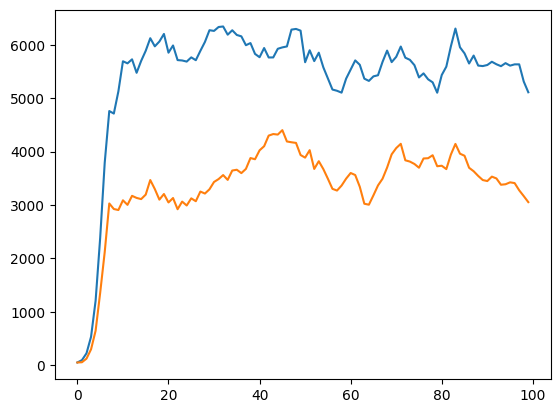

In [11]:
fig, ax = plt.subplots(1, 1)
ax.plot(sum_stock_n[0])
ax.plot(sum_stock_n[1])
plt.show()

In [39]:
np.savetxt("abundance.csv", results_n, delimiter=",")
np.savetxt("covariable.csv", results_cov, delimiter=",")

In [18]:
np.mean(results_n, axis=0)

array([46.784138, 31.820532])